# 01 - Generate Karstic Conduit Networks
Valentin Dall'Alba

__This notebook generates karstic conduit networks using the PyKasso library for hydrogeological simulations.__

- The conceptual model is a vertical cross-section, with a tunnel located at the bottom left.
- Model dimensions and parameters are defined in the following cells.
- the conduits diameters are estimated using a Gaussian Random Field (GRF) simulation.
- The karstic network is generated using PyKasso, with options to add bedding fractures.
- Multiple realizations of the karstic network can be created by varying the random seed.
- The generated networks will be used in subsequent hydrogeological simulation steps.

In [1]:
import pykasso as pk
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

In [ ]:
from generate_karst_functions import function_generate_karst

In [2]:
exec(open('generate_karst_functions/function_generate_karst.py').read())

## Model Caracteristics

We first definr the model caracteristics.

In [4]:
#model dimension
dim_x, dim_z   = 2000, 200 #Dimension in M
cell_x, cell_z = 1, 1 #Cell dimension in X and Z

#define the model class
karst_test     = Karst_networks(cell_x,cell_z,dim_x,dim_z)

#number of inlets
surface_inlets = 25
side_inlets    = 12
random_inlets  = 25

#number beddings
n_beddings = 10

#outlet(s) position(s)
x_o = 5
z_o = 5

#define karstic netwrok input/output parameters
karst_test.set_karst_input(surface_inlets,side_inlets,[[x_o,z_o]])


Outlets redefined


### GRF simulation for conduits diameter estimation

In [3]:
simu_grf = GRF_objt()
simu_grf.set_dimension()
simu_grf.run_model_GRF(nb_real=1)
simu_grf.grf_to_cdf()
simu_grf.cdf_to_diameter()
pipe_diameter = simu_grf.diameter[0]

Simulations are completed!
Simulation from SGS are transformed to conduits diameters!


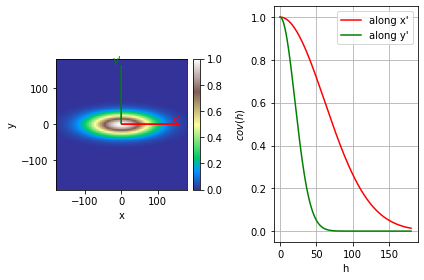

In [12]:
simu_grf.model_vario.plot_model(show_suptitle=False)
plt.tight_layout()

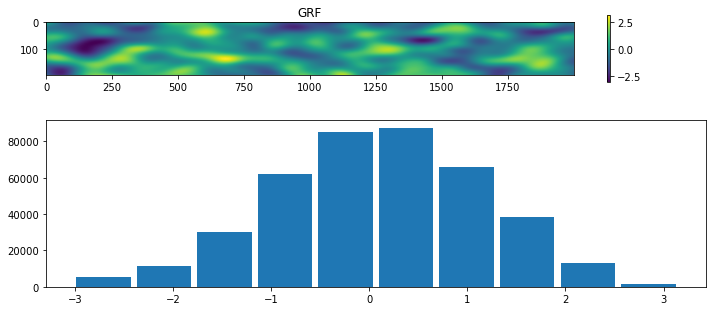

In [13]:
plt.subplots(2,1,figsize=(10,5))
plt.subplot(2,1,1)
plt.imshow(simu_grf.simu[0])
plt.colorbar(shrink=0.4)
plt.title('GRF')
plt.subplot(2,1,2)
plt.hist(simu_grf.simu[0].flatten(),rwidth=0.9)
plt.tight_layout()
plt.show()

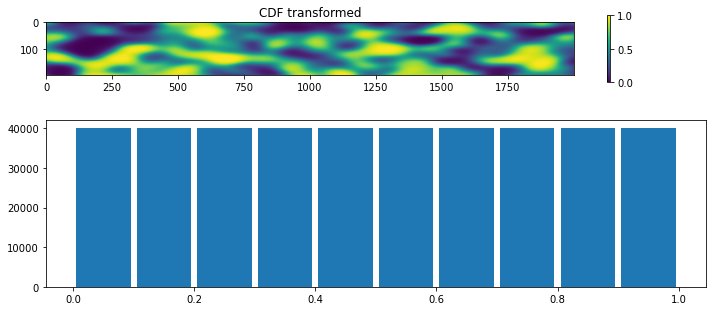

In [14]:
plt.subplots(2,1,figsize=(10,5))
plt.subplot(2,1,1)
plt.imshow(simu_grf.cdf[0])
plt.colorbar(shrink=0.4)
plt.title('CDF transformed')
plt.subplot(2,1,2)
plt.hist(simu_grf.cdf[0].flatten(),rwidth=0.9)
plt.tight_layout()
plt.show()

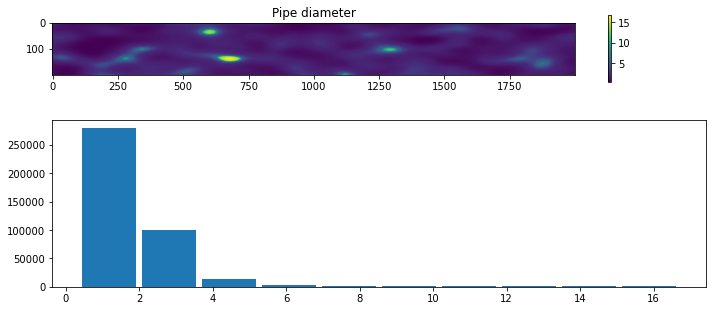

In [15]:
plt.subplots(2,1,figsize=(10,5))
plt.subplot(2,1,1)
plt.imshow(simu_grf.diameter[0])
plt.colorbar(shrink=0.4)
plt.title('Pipe diameter')
plt.subplot(2,1,2)
plt.hist(simu_grf.diameter[0].flatten(),rwidth=0.9)
plt.tight_layout()
plt.show()

## Karst Caracteristics
The next step is to prepare the configuration file for PyKasso.
An exemple of the parameters file is presented in the following cell below.

----
The stockastig network is then generated using the `run_pykasso_sks` function.
We can then add bedding fractures to the network using the `add_bed_fractures` function.
Finally, we compute the karstic network using the `compute_karst_network` function, which simulates the gradient of the network.

In [5]:
#define the parameters for the karstic network generation
Parameters_PyKart = {
"x0": 0,
"y0": 0,
"xnum" : karst_test.nx,
"ynum" : karst_test.ny,
"dx"   : cell_x,
"dy"   : cell_z,
"inlets_mode"   : 'composite',
"inlets_data"   : 'model_info/points_in.csv',
"inlets_number" : random_inlets,
"outlets_mode"   : 'composite',
"outlets_data"   : 'model_info/points_out.csv',
"outlets_number" : 0,
"geological_mode"     : 'null',
"faults_mode"          : 'null',
"fractures_mode"       : 'random',
"fractures_densities"       : [10e-5,8e-5,8e-5,10e-5],
"fractures_min_orientation" : [-5, 25, -30, 85],
"fractures_max_orientation" : [5, 30, -25, 95],
"alpha" : 1.7,
"fractures_min_length" : [200, 100, 100, 200],
"fractures_max_length" : [4000, 500, 500,4000],
"code_out"       : 0.1,
"code_aquifere"  : 2,
"code_aquiclude" : 1,
"code_faults"    : 4,
"code_fractures" : 4,
"code_conduits"  : 5,
"geology_id"       : [1,2],
"geology_velocity" : ['code_aquifere','code_aquiclude'],
"importance_factor" : [1,2],
"data_has_polygon" : False,
"rand_seed" : 123456789,
}

#set the karstic network parameters and write the input file
karst_test.set_pykasso_param(Parameters_PyKart)

#run the function to generate the sks map network
karst_test.run_pykasso_sks()

Pykasso parameters are sets!
Pykasso SKS is done!


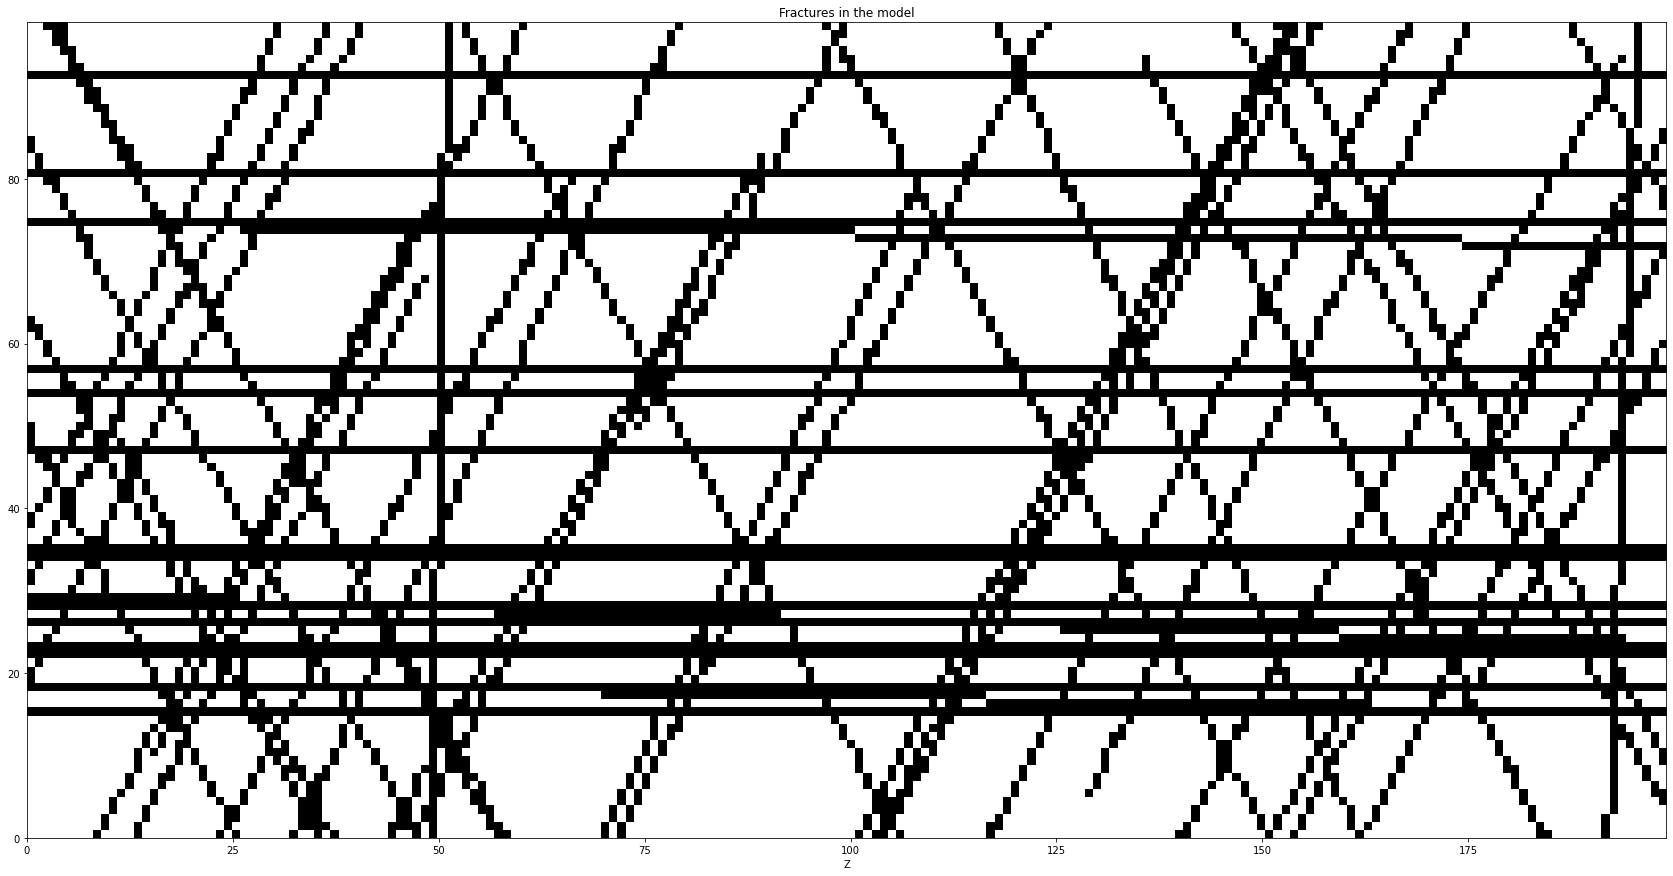


 This network contains  6  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


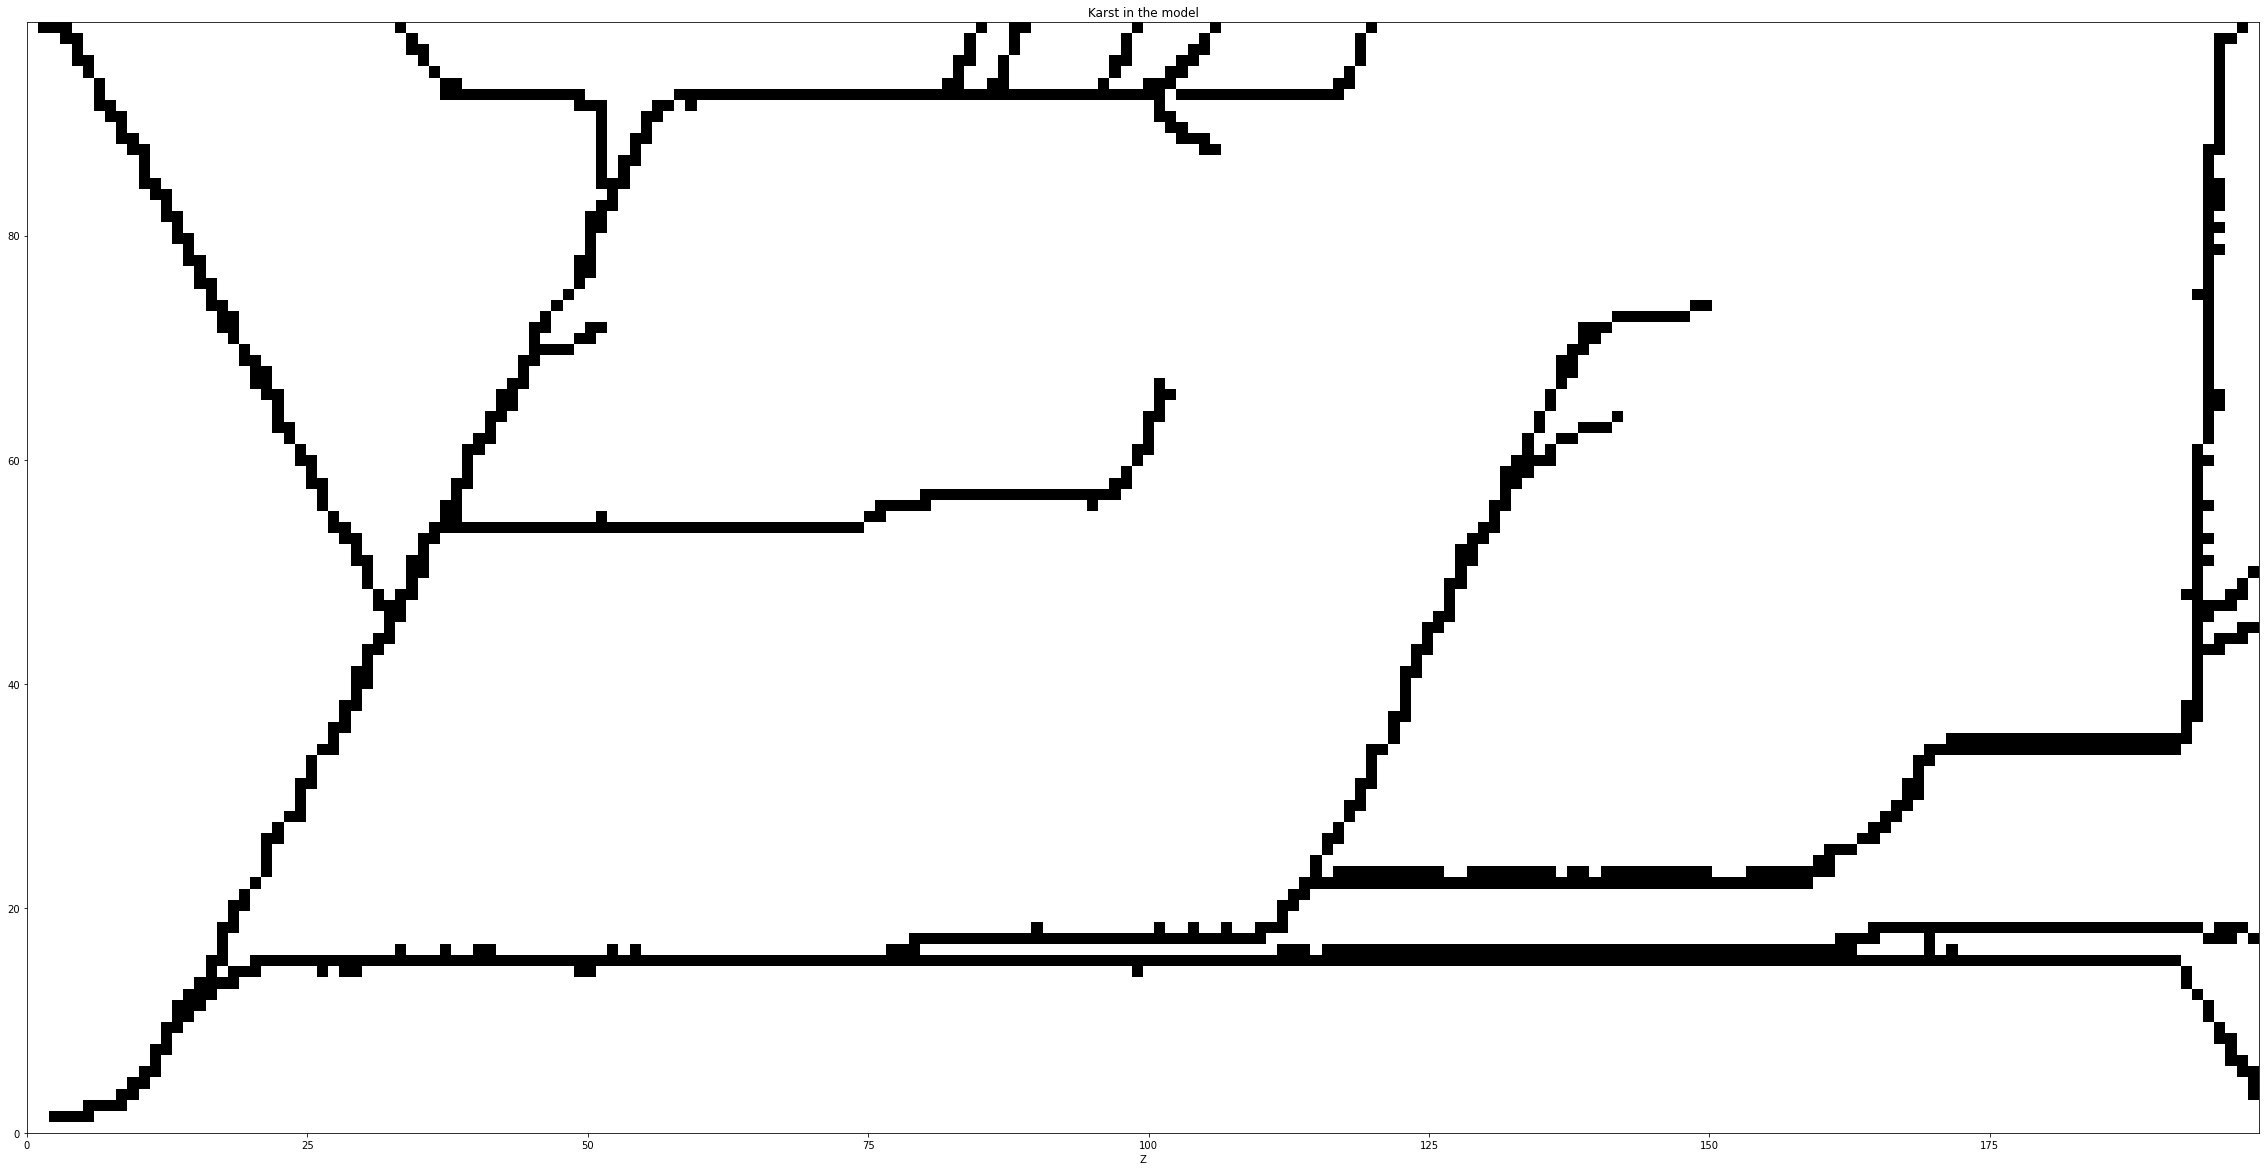

In [13]:
#gadd manually bed fracture to the fracture network
karst_test.add_bed_fractures(n_beddings)
karst_test.plot_fractures()

#compute the karstic network
karst_test.sks.compute_karst_network() #gradient simulation
karst_test.plot_karst()

## Create multi-realisation

In [6]:
#define simulations number and seeds
n_sims    = 50
init_seed = 200000000
seeds     = range(init_seed,init_seed+n_sims)

In [7]:
#generate the karstic networks multi-realisation
try:
    os.mkdir('pykasso_networks') #create the folder if it doesn't exists
except:
    print('Folder already exists')  
    
for seed in seeds:
    karst_test.set_karst_input(surface_inlets,side_inlets,[[x_o,z_o]])   
    karst_test.update(seed) #recalculate the fractures
    karst_test.add_bed_fractures(n_beddings)
    karst_test.sks.compute_karst_network() #gradient simulation
    print('------------ \n')
    print(str(seed-init_seed+1) + ' simulations')
    print('------------ \n')
    #karst_test.plot_karst()
    karst_test.export(seed,'cas1')


Folder already exists

Outlets redefined

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
------------ 

1 simulations
------------ 


Outlets redefined

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
------------ 

2 simulations
------------ 


Outlets redefined

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
------------ 

3 simulations
------------ 


Outlets redefined

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
------------ 

4 simulations
------------ 


Outlets redefined

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
------------ 

5 simulations
------------ 


Outlets redefined

Computing:
 - mean length,cv length,length entropy,mean to